In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split

import pickle

# Load Data

In [3]:
model_df = pd.read_csv('../model_df.csv')

# Train Test Split

In [5]:
def tts(data):
    data = data.drop(['sales','date'],axis=1)
    train, test = data[0:-12].values, data[-12:].values
    
    return train, test

train, test = tts(model_df)

In [6]:
train.shape

(35, 13)

In [7]:
test.shape

(12, 13)

In [8]:
def scale_data(train_set, test_set):
    #apply Min Max Scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_set)
    
    # reshape training set
    train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
    train_set_scaled = scaler.transform(train_set)
    
    # reshape test set
    test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
    test_set_scaled = scaler.transform(test_set)
    
    X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1].ravel()
    X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1].ravel()
    
    return X_train, y_train, X_test, y_test, scaler

X_train, y_train, X_test, y_test, scaler_object = scale_data(train, test)

In [9]:
y_train.shape

(35,)

# Modeling Functions

In [10]:
def undo_scaling(y_pred, x_test, scaler_obj, lstm=False):  
    #reshape y_pred
    y_pred = y_pred.reshape(y_pred.shape[0], 1, 1)
    
    if not lstm:
        x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])
    
    #rebuild test set for inverse transform
    pred_test_set = []
    for index in range(0,len(y_pred)):
        pred_test_set.append(np.concatenate([y_pred[index],x_test[index]],axis=1))
        
    #reshape pred_test_set
    pred_test_set = np.array(pred_test_set)
    pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
    
    #inverse transform
    pred_test_set_inverted = scaler_obj.inverse_transform(pred_test_set)
    
    return pred_test_set_inverted

In [19]:
def load_original_df():
    #load in original dataframe without scaling applied
    original_df = pd.read_csv('../train.csv')
    original_df.date = original_df.date.apply(lambda x: str(x)[:-3])
    original_df = original_df.groupby('date')['sales'].sum().reset_index()
    original_df.date = pd.to_datetime(original_df.date)
    return original_df

In [20]:
def predict_df(unscaled_predictions, original_df):
    #create dataframe that shows the predicted sales
    result_list = []
    sales_dates = list(original_df[-13:].date)
    act_sales = list(original_df[-13:].sales)
    
    for index in range(0,len(unscaled_predictions)):
        result_dict = {}
        result_dict['pred_value'] = int(unscaled_predictions[index][0] + act_sales[index])
        result_dict['date'] = sales_dates[index+1]
        result_list.append(result_dict)
        
    df_result = pd.DataFrame(result_list)
    
    return df_result

In [21]:
model_scores = {}

def get_scores(unscaled_df, original_df, model_name):
    rmse = np.sqrt(mean_squared_error(original_df.sales[-12:], unscaled_df.pred_value[-12:]))
    mae = mean_absolute_error(original_df.sales[-12:], unscaled_df.pred_value[-12:])
    r2 = r2_score(original_df.sales[-12:], unscaled_df.pred_value[-12:])
    model_scores[model_name] = [rmse, mae, r2]

    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2 Score: {r2}")

In [22]:
def plot_results(results, original_df, model_name):

    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(original_df.date, original_df.sales, data=original_df, ax=ax, 
                 label='Original', color='mediumblue')
    sns.lineplot(results.date, results.pred_value, data=results, ax=ax, 
                 label='Predicted', color='Red')
    
    ax.set(xlabel = "Date",
           ylabel = "Sales",
           title = f"{model_name} Sales Forecasting Prediction")
    
    ax.legend()
    
    sns.despine()
    
    plt.savefig(f'../model_output/{model_name}_forecast.png')

In [23]:
def run_model(train_data, test_data, model, model_name):
    
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)
    
    mod = model
    mod.fit(X_train, y_train)
    predictions = mod.predict(X_test)
    
    # Undo scaling to compare predictions against original data
    original_df = load_original_df()
    unscaled = undo_scaling(predictions, X_test, scaler_object)
    unscaled_df = predict_df(unscaled, original_df)
      
    get_scores(unscaled_df, original_df, model_name)
    
    plot_results(unscaled_df, original_df, model_name)

# Linear Regression

RMSE: 16221.040790693221
MAE: 12433.0
R2 Score: 0.9907155879704752


c:\users\panda\desktop\testsy\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\users\panda\desktop\testsy\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


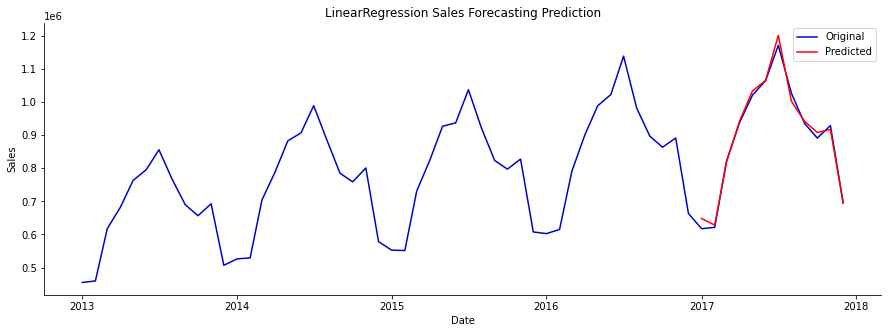

In [24]:
run_model(train, test, LinearRegression(), 'LinearRegression')

# Random Forest Regressor

RMSE: 17447.26748901768
MAE: 14065.333333333334
R2 Score: 0.9892588245237498


c:\users\panda\desktop\testsy\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\users\panda\desktop\testsy\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


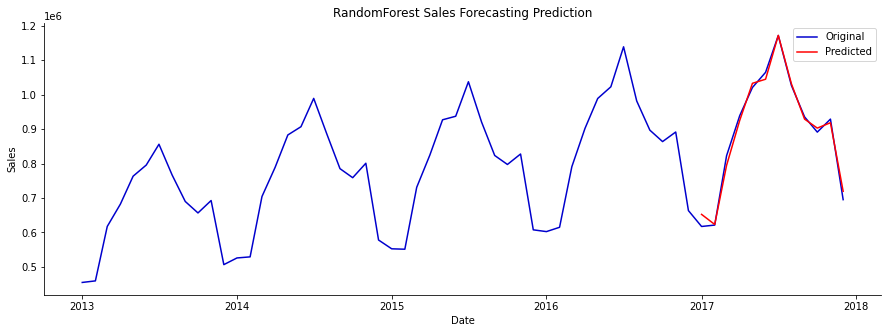

In [25]:
run_model(train, test, RandomForestRegressor(n_estimators=100, max_depth=20), 
          'RandomForest')

# XGBoost

RMSE: 15701.003359658262
MAE: 13342.666666666666
R2 Score: 0.9913013514225064


c:\users\panda\desktop\testsy\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\users\panda\desktop\testsy\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


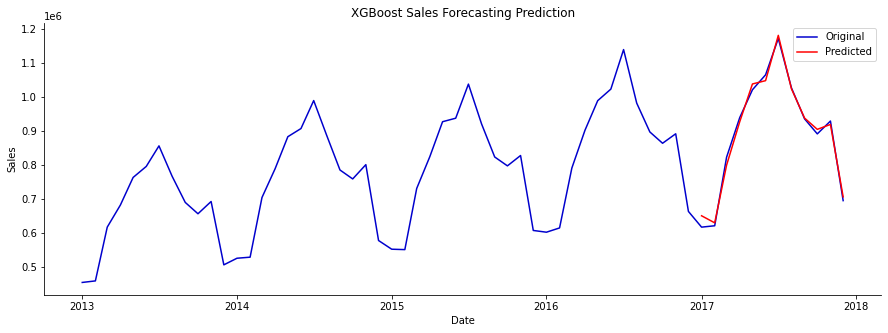

In [26]:
run_model(train, test, XGBRegressor( n_estimators=100, 
                                    learning_rate=0.2, 
                                    objective='reg:squarederror'), 'XGBoost')

# LSTM

In [27]:
def lstm_model(train_data, test_data):
    
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)
    
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
   
    model = Sequential()
    model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), 
                   stateful=True))
    model.add(Dense(1))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=200, batch_size=1, verbose=1, 
              shuffle=False)
    predictions = model.predict(X_test,batch_size=1)
    
    original_df = load_original_df()
    unscaled = undo_scaling(predictions, X_test, scaler_object, lstm=True)
    unscaled_df = predict_df(unscaled, original_df)
    
    get_scores(unscaled_df, original_df, 'LSTM')
    
    plot_results(unscaled_df, original_df, 'LSTM')

Epoch 1/200
35/35 [==============================] - 3s 3ms/step - loss: 0.2680
Epoch 2/200
35/35 [==============================] - 0s 3ms/step - loss: 0.2550
Epoch 3/200
35/35 [==============================] - 0s 3ms/step - loss: 0.2370
Epoch 4/200
35/35 [==============================] - 0s 3ms/step - loss: 0.2196
Epoch 5/200
35/35 [==============================] - 0s 3ms/step - loss: 0.2027
Epoch 6/200
35/35 [==============================] - 0s 3ms/step - loss: 0.1864
Epoch 7/200
35/35 [==============================] - 0s 3ms/step - loss: 0.1707
Epoch 8/200
35/35 [==============================] - 0s 3ms/step - loss: 0.1554
Epoch 9/200
35/35 [==============================] - 0s 3ms/step - loss: 0.1406
Epoch 10/200
35/35 [==============================] - 0s 3ms/step - loss: 0.1264
Epoch 11/200
35/35 [==============================] - 0s 3ms/step - loss: 0.1130
Epoch 12/200
35/35 [==============================] - 0s 3ms/step - loss: 0.1007
Epoch 13/200
35/35 [=================

35/35 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 102/200
35/35 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 103/200
35/35 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 104/200
35/35 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 105/200
35/35 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 106/200
35/35 [==============================] - 0s 4ms/step - loss: 0.0035
Epoch 107/200
35/35 [==============================] - 0s 4ms/step - loss: 0.0035
Epoch 108/200
35/35 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 109/200
35/35 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 110/200
35/35 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 111/200
35/35 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 112/200
35/35 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 113/200
35/35 [=========

35/35 [==============================] - ETA: 0s - loss: 0.0018    - 0s 3ms/step - loss: 0.0020
RMSE: 16806.879737179057
MAE: 13126.5
R2 Score: 0.990032846247416


c:\users\panda\desktop\testsy\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\users\panda\desktop\testsy\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


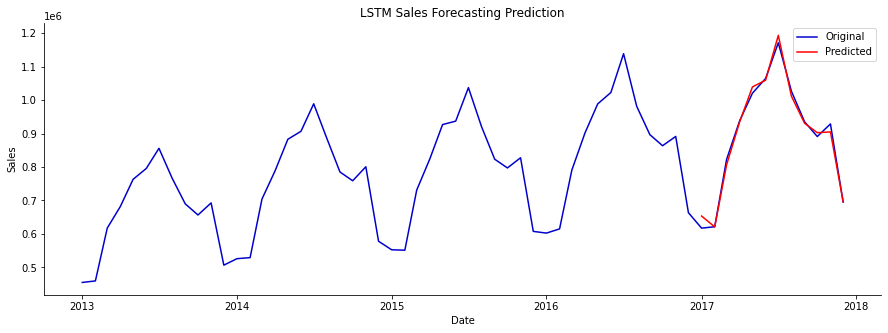

In [28]:
lstm_model(train, test)

In [29]:
pickle.dump(model_scores, open( "model_scores.p", "wb" ) )

In [30]:
model_scores

{'LinearRegression': [16221.040790693221, 12433.0, 0.9907155879704752],
 'RandomForest': [17447.26748901768, 14065.333333333334, 0.9892588245237498],
 'XGBoost': [15701.003359658262, 13342.666666666666, 0.9913013514225064],
 'LSTM': [16806.879737179057, 13126.5, 0.990032846247416]}